In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_openml
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

data= fetch_openml('mnist_784', version=1)#Get data from https://www.openml.org/d/554
dfData = pd.DataFrame(np.c_[data["data"],data["target"]],columns = data["feature_names"]+["target"])

In [2]:
stratSplit = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)

for train_index, test_index in stratSplit.split(dfData[data["feature_names"]], dfData["target"]):
    X_train = dfData[data["feature_names"]].iloc[train_index]
    X_test = dfData[data["feature_names"]].iloc[test_index]
    
    y_train = dfData["target"].iloc[train_index]
    y_test = dfData["target"].iloc[test_index]

In [3]:
from sklearn.ensemble import VotingClassifier

ests = []
for i in range(10):
    ests.append((f'dec_tree_{i}',DecisionTreeClassifier(max_depth=3,
                                                      max_features='sqrt',
                                                      splitter='random')))
vote_clf = VotingClassifier(estimators=ests,
                          voting='hard', # soft
                          weights=None, # weights for each classifier as a list
                                        # a good way to get weights is to base them off of relative performance
                                        # in previous CV runs
                          n_jobs=2,
                          flatten_transform=True # only relevant for soft voting, affects output shape
                          )

vote_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('dec_tree_0',
                              DecisionTreeClassifier(ccp_alpha=0.0,
                                                     class_weight=None,
                                                     criterion='gini',
                                                     max_depth=3,
                                                     max_features='sqrt',
                                                     max_leaf_nodes=None,
                                                     min_impurity_decrease=0.0,
                                                     min_impurity_split=None,
                                                     min_samples_leaf=1,
                                                     min_samples_split=2,
                                                     min_weight_fraction_leaf=0.0,
                                                     presort='deprecated',
                                                     random_state=No

In [4]:
for estimator,est_name in zip(vote_clf.estimators_,vote_clf.named_estimators_):
    print(f'{est_name}:',round(estimator.score(X_test,y_test.astype(int)),3))
print('Voting classifier:',round(vote_clf.score(X_test,y_test),3))

dec_tree_0: 0.358
dec_tree_1: 0.335
dec_tree_2: 0.369
dec_tree_3: 0.384
dec_tree_4: 0.353
dec_tree_5: 0.373
dec_tree_6: 0.383
dec_tree_7: 0.368
dec_tree_8: 0.334
dec_tree_9: 0.37
Voting classifier: 0.527


In [5]:
vote_clf_soft = VotingClassifier(estimators=[
                                        ('log_reg',LogisticRegression()),
                                        ('dec_tree',DecisionTreeClassifier(max_depth=3)),
                                        ('GaussianNB',GaussianNB())
                                        ],
                          voting='soft', # soft
                          weights=None, # weights for each classifier as a list
                          n_jobs=2,
                          flatten_transform=True # only relevant for soft voting
                          )

vote_clf_soft.fit(X_train, y_train)

VotingClassifier(estimators=[('log_reg',
                              LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=None,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False)),
                             ('dec_tree',
                              DecisionTreeClassifier(ccp_alpha=0.0,
                                                     class_weight=None,
                                                     criter...gini',
                                  

In [6]:
for estimator,est_name in zip(vote_clf_soft.estimators_,vote_clf_soft.named_estimators_):
    print(f'{est_name}:',round(estimator.score(X_test,y_test.astype(int)),3))
print('Soft voting classifier:',round(vote_clf_soft.score(X_test,y_test),3))

log_reg: 0.925
dec_tree: 0.494
GaussianNB: 0.55
Soft voting classifier: 0.766


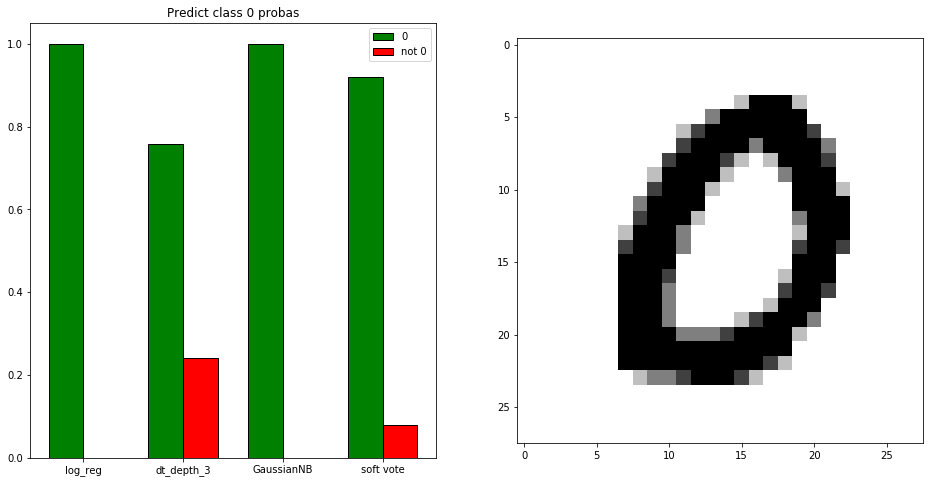

In [7]:
ind = 1

probas = []
for estimator,est_name in zip(vote_clf_soft.estimators_,vote_clf_soft.named_estimators_):
    probas.append(estimator.predict_proba(X_test[ind:ind+1]))

probas.append(vote_clf_soft.predict_proba(X_test[ind:ind+1]))

pred_class = int(y_test.values[ind])
fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(121)
i = 0
w = 0.35
for prob in probas:
    predNot = 0
    predIs = 0
    for k in range(len(prob[0])):
        if k == pred_class:
            predIs += prob[0, k]
        else:
            predNot += prob[0, k]
    if i == 0:
        bars = plt.bar([i-w/2,i+w/2],height=[predIs,predNot],color=["green","red"],width=w,edgecolor='black')
    else:
        plt.bar([i-w/2,i+w/2],height=[predIs,predNot],color=["green","red"],width=w,edgecolor='black')

    i +=1

plt.xticks(range(len(probas)),['log_reg','dt_depth_3',
                               'GaussianNB',
                               'soft vote'])
plt.title(f"Predict class {pred_class} probas")
plt.legend([bars[0], bars[1]], [f'{pred_class}', f'not {pred_class}'])
ax = fig.add_subplot(122)
plt.imshow(X_test.iloc[ind].astype(int).values.reshape(28,-1),cmap=plt.get_cmap('gray_r'))
plt.show()

In [8]:
probas

[array([[9.99968177e-01, 3.82282577e-16, 1.31882908e-06, 6.98137424e-09,
         2.11840545e-09, 2.91529443e-06, 9.51239969e-06, 3.62005840e-11,
         1.80451475e-05, 2.21905320e-08]]),
 array([[0.75868726, 0.001755  , 0.07844858, 0.02650053, 0.00579151,
         0.07704458, 0.03369603, 0.002457  , 0.01175851, 0.003861  ]]),
 array([[1.00000000e+000, 0.00000000e+000, 0.00000000e+000,
         0.00000000e+000, 0.00000000e+000, 5.27376351e-310,
         5.68545834e-286, 0.00000000e+000, 2.20643927e-140,
         0.00000000e+000]]),
 array([[9.19551812e-01, 5.85000585e-04, 2.61499658e-02, 8.83351116e-03,
         1.93050264e-03, 2.56824974e-02, 1.12351820e-02, 8.19000831e-04,
         3.92551897e-03, 1.28700868e-03]])]